# Topic Modeling (Prepare)

On Monday we talked about summarizing your documents using just token counts. Today, we're going to learn about a much more sophisticated approach - learning 'topics' from documents. Topics are a latent structure. They are not directly observable in the data, but we know they're there by reading them.

> **latent**: existing but not yet developed or manifest; hidden or concealed.

## Use Cases
Primary use case: what the hell are your documents about? Who might want to know that in industry - 
* Identifying common themes in customer reviews
* Discovering the needle in a haystack 
* Monitoring communications (Email - State Department) 

## Learning Objectives
*At the end of the lesson you should be able to:*
* Part 0: Warm-Up
* Part 1: Describe how an LDA Model works
* Part 2: Estimate a LDA Model with Gensim
* Part 3: Interpret LDA results & Select the appropriate number of topics

# Part 0: Warm-Up
How do we do a grid search? 

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping, defaultdict
/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# Load training data
newsgroups_train = fetch_20newsgroups(subset='train', 
                                      remove=('headers', 'footers', 'quotes'))

# Load testing data
newsgroups_test = fetch_20newsgroups(subset='test', 
                                     remove=('headers', 'footers', 'quotes'))

print(f'Training Samples: {len(newsgroups_train.data)}')
print(f'Testing Samples: {len(newsgroups_test.data)}')

Training Samples: 11314
Testing Samples: 7532


In [4]:
newsgroups_train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR', 'description'])

In [5]:
newsgroups_train['target_names']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [6]:
newsgroups_train['data'][1000]

"Anybody seen mouse cursor distortion running the Diamond 1024x768x256 driver?\nSorry, don't know the version of the driver (no indication in the menus) but it's a recently\ndelivered Gateway system.  Am going to try the latest drivers from Diamond BBS but wondered\nif anyone else had seen this.\n\npost or email"

### GridSearch on Just Classifier
* Fit the vectorizer and prepare BEFORE it goes into the gridsearch

In [7]:
# Instantiate vectorizer
vect = TfidfVectorizer(min_df=5)

# Transform the training data
X_train = vect.fit_transform(newsgroups_train['data'])
print(X_train.shape)

(11314, 18101)


In [8]:
params_1 = {
    'min_samples_leaf': [1, 2, 5, 10]
}

# Instantiate classifier
clf = RandomForestClassifier()

# GridSearch
gs1 = GridSearchCV(clf, params_1, cv=5, n_jobs=-1, verbose=1)
gs1.fit(X_train, newsgroups_train['target'])

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    6.2s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'min_samples_leaf': [1, 2, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [9]:
gs1.best_score_

0.5424253137705498

In [10]:
gs1.best_params_

{'min_samples_leaf': 5}

In [11]:
test_sample = vect.transform(["The new york yankees are the best team in the region."])
test_sample.shape

(1, 18101)

In [12]:
gs1.predict(test_sample)[0]

10

In [13]:
newsgroups_train['target_names'][9]

'rec.sport.baseball'

### GridSearch with BOTH the Vectoizer & Classifier

In [14]:
from sklearn.pipeline import Pipeline

# 1. Create a pipeline with a vectorize and a classifier
# 2. Use Grid Search to optimize the entire pipeline
pipe = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', RandomForestClassifier(random_state=42))
])

params_2 = {
    'vect__stop_words': (None, 'english'), 
    'vect__min_df': (2, 5),
    'clf__max_depth': (10, None)
}

gs2 = GridSearchCV(pipe, params_2, cv=5, n_jobs=-1, verbose=1)
gs2.fit(newsgroups_train['data'], newsgroups_train['target'])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   55.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...stimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'vect__stop_words': (None, 'english'), 'vect__min_df': (2, 5), 'clf__max_depth': (10, None)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [15]:
gs2.best_score_

0.56655471097755

In [16]:
gs2.best_params_

{'clf__max_depth': None, 'vect__min_df': 5, 'vect__stop_words': 'english'}

In [17]:
pred = gs2.predict(["The new york yankees are the best team in the region."])
pred

array([9])

In [18]:
newsgroups_train['target_names'][pred[0]]

'rec.sport.baseball'

Advantages to using GS with the Pipe:
* Allows us to make predictions on raw text increasing reproducibility. :)
* Allows us to tune the parameters of the vectorizer along side the classifier. :D 

# Part 1: Describe how an LDA Model works

[Your Guide to Latent Dirichlet Allocation](https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d)

[LDA Topic Modeling](https://lettier.com/projects/lda-topic-modeling/)

[Topic Modeling with Gensim](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

In [19]:
# Download spacy model
import spacy.cli
spacy.cli.download("en_core_web_lg")

⚠ Skipping model package dependencies and setting `--no-deps`. You
don't seem to have the spaCy package itself installed (maybe because you've
built from source?), so installing the model dependencies would cause spaCy to
be downloaded, which probably isn't what you want. If the model package has
other dependencies, you'll have to install them manually.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [20]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
df = pd.DataFrame({
    'content': newsgroups_train['data'],
    'target': newsgroups_train['target'],
    'target_names': [newsgroups_train['target_names'][i] for i in newsgroups_train['target']]
})
print(df.head(1))

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             content  \
0  I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.   

   target target_names 

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
pd.set_option('display.max_colwidth', 0)
df.sample(3)

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


content  \
8391   Gordon Rubenfeld responds to Ron Roth:\nGR>\nGR> RR> Well, Gordon, I look at the RESULTS, not at anyone's *scientific*\nGR> RR> stamp of approval.\nGR>  \nGR>    If you and your patients (followers?) are convinced (as you've written)\nGR>  by your methods of uncontrolled, undocumented, unreported, unsubstantiated,\nGR>  subjective endpoint research - great.  But, why should the rest of us care?\n\n Gordon, even if you are trying to beat this issue to death, you'll \n never get more than a stalemate out of this one!\n I have never tried to force my type of medicine on any of you. Why \n should I?  My patients are happy. I'm happy. You and your peers seem \n to be the only miserable ones around bemoaning the steady loss of \n patients to the alternative camp.\n Just look at Europe. There has been a steady exodus from 'synthetic' \n medicine for over a decade now, and it'll be just a matter of time\n before more people on this continent will abandon their drug and white \n coat worship as well and visit different doctors for different needs.\n\nGR>     You see Ron, the point isn't whether YOU and your patients are\nGR>  convinced that whatever it is you do works; it's whether what you do is\nGR>  MORE effective in similar cases (of whatever it is you think you are\nGR>  treating) than cupping, bloodletting, and placebo.\n\n This is very interesting. I have come exactly to the same conclusions\n but in regards to *conventional* medicine.\n\n You see, I don't just treat little old ladies that wouldn't know any\n different of what is being done, but a bulk of my patients consist of\n teachers, lawyers, judges, nurses, accountants, university graduates,\n and various health practitioners.\n If these people have gotten results with my method after having been\n unsuccessful with yours or their own, I certainly wouldn't lose any \n sleep over whether you or your peers approve of my treatments --- \n let's face it, with all the blunders committed by "scientific" MDs \n over the years, I know a lot of people who hold your *scientific* \n method in much lower esteem than they hold mine!\n\nGR>  As far as we know ayurveda = crystals = homeopathy = Ron Roth\nGR>  which may all equal placebo administered with appropriate\nGR>  trappings...\n     \n  Sorry, but I'm not familiar OR interested with what appears to be \n 'NEW AGE' medicine (ayurveda, crystals), with the exception of homeo-\n pathy, of which I took a course. But Gordon, you already knew that -\n you just wanted to make my system look a bit more far out, right?\n \n I use homeopathy very little, since my cellular test (EMR) is hard to\n beat for accuracy and minerals are more predictable, while homeopathy\n does have a problem with reliability, especially in acute conditions.\n An exception perhaps are homeopathic nosodes which act fairly quickly\n and are more dependable in certain viral or bacterial situations. \n\nGR>  My colleagues and I spend hours debating study design\nGR>  and results, even of therapies currently accepted as "standard".\nGR>  As good (well, adequate) scientists, we are prepared, *if \nGR>  presented with appropriate data*, to abandon our most deeply held \nGR>  beliefs in favor of new ideas.\n\n I have met the challenges of hundreds of sceptics by verifying the\n accuracy of measuring their mineral status to their total satisfac-\n tion --- in other words EVERYONE INVOLVED is happy!\n If you were to cook a meal, would you worry over whether EVERYONE \n in this world would find it to their liking, or only those that end \n up eating it?\n Since I have financed every research project that I have undertaken \n entirely myself, I don't need to follow any of your rules or guide-\n lines to satisfy any aspects of a grant application, which YOU may \n have to; neither am I concerned of whether or not my study designs \n meet your or anyone else's criteria or acceptance. \n\nGR>    Sorry Ron, if conviction were the ruler of truth, a flat Earth wo

In [23]:
' '.join("  The apple has         fallen from the tree.  ".split())

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'The apple has fallen from the tree.'

In [24]:
# For reference on regex: https://docs.python.org/3/library/re.html
# From 'content' column: 

# 1. Remove new line characters
df['clean_text'] = df['content'].apply(lambda x: re.sub('\s+', ' ', x))

# 2. Remove Emails
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub('From: \S+@\S+', '', x))

# 3. Remove non-alphanumeric characters
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

# 4. Remove extra whitespace 
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join(x.split()))

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:5: DeprecationWarning: invalid escape sequence \s
<>:8: DeprecationWarning: invalid escape sequence \S
<>:5: DeprecationWarning: invalid escape sequence \s
<>:8: DeprecationWarning: invalid escape sequence \S
<ipython-input-24-ef192abb48ae>:5: DeprecationWarning: invalid escape sequence \s
  df['clean_text'] = df['content'].apply(lambda x: re.sub('\s+', ' ', x))
<ipython-input-24-ef192abb48ae>:8: DeprecationWarning: invalid escape sequence \S
  df['clean_text'] = df['clean_text'].apply(lambda x: re.sub('From: \S+@\S+', '', x))


In [25]:
df.sample(3)

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,target,target_names,clean_text
11011,"\n\n\tAnd the Commonwealth of Virginia has not exactly butted\nagainst the issue on those grounds. The claim is that AS A MATTER\nOF TRAFFIC SAFETY one is not allowed to have a functioning radar\ndetector on the dashboard while operating a motor vehicle.\n\n\tYes, the argument is bogus, BUT... it hasn't been successfully\nchallenged in court. Yet.",12,sci.electronics,And the Commonwealth of Virginia has not exactly butted against the issue on those grounds The claim is that AS A MATTER OF TRAFFIC SAFETY one is not allowed to have a functioning radar detector on the dashboard while operating a motor vehicle Yes the argument is bogus BUT it hasn t been successfully challenged in court Yet
2788,"Grf. Dropped my Shoei RF-200 off the seat of my bike while trying to rock \nit onto it's centerstand, chipped the heck out of the paint on it...\n \n So I cheerfully spent $.59 on a bottle of testor's model paint and \nrepainted the scratches and chips for 20 minutes.\n \n Then, while it was drying, I realized that I was out of smokes and that my \ncage is not currently running... So I ""had to"" take my bike down to the \nstore. Not wanting to mess up my paint job, I said ""Well, heck. I can just \nuse my old helmet"".... this is your standard el cheapie openface... \n \n I didn't notice a big difference when I switched TO the shoei, but \nswitching back was really bad... \n \n 1) Doesn't fit worth a damn, too wide in the sides, too short front to \nback...\n 2) With a faceplate, it's still bloody windy... with the shoei, I normally \nignore the face shield until I get up to about 30ish... with this one, \ntaxiing to the end of the driveway was too smegging much wind. \n \n",8,rec.motorcycles,Grf Dropped my Shoei RF off the seat of my bike while trying to rock it onto it s centerstand chipped the heck out of the paint on it So I cheerfully spent on a bottle of testor s model paint and repainted the scratches and chips for minutes Then while it was drying I realized that I was out of smokes and that my cage is not currently running So I had to take my bike down to the store Not wanting to mess up my paint job I said Well heck I can just use my old helmet this is your standard el cheapie openface I didn t notice a big difference when I switched TO the shoei but switching back was really bad Doesn t fit worth a damn too wide in the sides too short front to back With a faceplate it s still bloody windy with the shoei I normally ignore the face shield until I get up to about ish with this one taxiing to the end of the driveway was too smegging much wind
10821,"I've been reading, with much confusion, about whether or not to use\nATManager. Lately, all the packages I've been buying have all\nincluded ATManager as a ""bonus""\nI do some desktop publishing using PageMaker and Coreldraw.\nCoreldraw comes with a nifty laser disk that contains over 200 diff\ntypes. Add that to the TTfonts that come with win31 and you have a\ndecent amount of fonts. I print my creations out on an HP4\nPostcript, at 600 dpi resolution with the ""Resolution Enhancement \nTechnology"" and .. well ... I get some darn good copies. \nSo good that there isn't any diff whether or not ATManager is turned\non or not. Is it worth it to run ATM at all? Especially with these\nbetter printer technologies ... and TT?",2,comp.os.ms-windows.misc,I ve been reading with much confusion about whether or not to use ATManager Lately all the packages I ve been buying have all included ATManager as a bonus I do some desktop publishing using PageMaker and Coreldraw Coreldraw comes with a nifty laser disk that contains over diff types Add that to the TTfonts that come with win and you have a decent amount of fonts I print my creations out on an HP Postcript at dpi resolution with the Resolution Enhancement Technology and well I get some darn good copies So good that there isn t any diff whether or not ATManager is turned on or not Is it worth it t

In [26]:
nlp = spacy.load("en_core_web_lg")

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
# Leverage tqdm for progress_apply
from tqdm import tqdm
tqdm.pandas()

# If you're on macOS, Linux, or python session executed from Windows Subsystem for Linux (WSL)
# conda activate U4-S1-NLP
# pip install pandarallel
#
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
#
# df['lemmas'] = df['content'].parallel_apply(get_lemmas)
#
# Ref: https://github.com/nalepae/pandarallel

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
# Create 'lemmas' column
def get_lemmas(x):
    lemmas = []
    for token in nlp(x):
        if (token.is_stop!=True) and (token.is_punct!=True):
            lemmas.append(token.lemma_)
    return lemmas

df['lemmas'] = df['clean_text'].progress_apply(get_lemmas)

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 11314/11314 [06:15<00:00, 30.11it/s]


In [29]:
df.head()

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,target,target_names,clean_text,lemmas
0,"I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.",7,rec.autos,I was wondering if anyone out there could enlighten me on this car I saw the other day It was a door sports car looked to be from the late s early s It was called a Bricklin The doors were really small In addition the front bumper was separate from the rest of the body This is all I know If anyone can tellme a model name engine specs years of production where this car is made history or whatever info you have on this funky looking car please e mail,"[wonder, enlighten, car, see, day, door, sport, car, look, late, s, early, s, call, Bricklin, door, small, addition, bumper, separate, rest, body, know, tellme, model, engine, spec, year, production, car, history, info, funky, look, car, e, mail]"
1,"A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't answered this\npoll. Thanks.",4,comp.sys.mac.hardware,A fair number of brave souls who upgraded their SI clock oscillator have shared their experiences for this poll Please send a brief message detailing your experiences with the procedure Top speed attained CPU rated speed add on cards and adapters heat sinks hour of usage per day floppy disk functionality with and m floppies are especially requested I will be summarizing in the next two days so please add to the network knowledge base if you have done the clock upgrade and haven t answered this poll Thanks,"[fair, number, brave, soul, upgrade, SI, clock, oscillator, share, experience, poll, send, brief, message, detail, experience, procedure, speed, attain, CPU, rate, speed, add, card, adapter, heat, sink, hour, usage, day, floppy, disk, functionality, m, floppy, especially, request, summarize, day, add, network, knowledge, base, clock, upgrade, haven, t, answer, poll, thanks]"
2,"well folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985. sooo, i'm in the market for a\nnew machine a bit sooner than i intended to be...\n\ni'm looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\n* does anybody know any dirt on when the next round of powerbook\nintroductions are expected? i'd heard the 185c was supposed to make an\nappearence ""this summer"" but haven't heard anymore on it - and since i\ndon't have access to macleak, i was wondering if anybody out there had\nmore info...\n\n* has anybody heard rumors about price drops to the powerbook line like the\nones the duo's just went through recently?\n\n* what's the impression of the display on the 180? i could probably swing\na 180 if i got the 80Mb disk rather than the 120, but i don't really have\na feel for how much ""better"" the display is (yea, it looks great in the\nstore, but is that all ""wow"" or is it really that good?). could i solicit\nsome opinions of people who use the 160 and 180 day-to-day on if its worth\ntaking the disk size and money hit to get the active display? (i realize\nthis is a real subjective question, but i've only played around with the\nmachines in a compu

### The two main inputs to the LDA topic model are the dictionary (id2word) and the corpus.

In [30]:
# Create Dictionary
id2word = corpora.Dictionary(df['lemmas'])

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
# How many words do we have?
len(id2word.keys())

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


79051

In [32]:
# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=3, no_above=0.75)

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
# How many words do we have?
len(id2word.keys())

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


22940

In [34]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in df['lemmas']]

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
id2word[109]

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'hear'

In [36]:
df.iloc[5]['clean_text']

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'Of course The term must be rigidly defined in any bill I doubt she uses this term for that You are using a quote allegedly from her can you back it up I read the article as presenting first an argument about weapons of mass destruction as commonly understood and then switching to other topics The first point evidently was to show that not all weapons should be allowed and then the later analysis was given this understanding to consider another class'

In [37]:
corpus[5]

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(105, 1),
 (163, 1),
 (180, 1),
 (206, 1),
 (210, 1),
 (211, 1),
 (212, 1),
 (213, 1),
 (214, 1),
 (215, 1),
 (216, 1),
 (217, 1),
 (218, 1),
 (219, 1),
 (220, 1),
 (221, 1),
 (222, 1),
 (223, 1),
 (224, 1),
 (225, 1),
 (226, 1),
 (227, 1),
 (228, 1),
 (229, 1),
 (230, 2),
 (231, 1),
 (232, 1),
 (233, 2)]

In [38]:
id2word[105]

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'give'

In [39]:
id2word[232]

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'understand'

In [40]:
# Human readable format of corpus (term-frequency)
[(id2word[word_id], word_count) for word_id, word_count in corpus[5]]

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('give', 1),
 ('use', 1),
 ('article', 1),
 ('understanding', 1),
 ('allegedly', 1),
 ('allow', 1),
 ('analysis', 1),
 ('argument', 1),
 ('bill', 1),
 ('class', 1),
 ('commonly', 1),
 ('consider', 1),
 ('course', 1),
 ('define', 1),
 ('destruction', 1),
 ('doubt', 1),
 ('evidently', 1),
 ('later', 1),
 ('mass', 1),
 ('point', 1),
 ('present', 1),
 ('quote', 1),
 ('read', 1),
 ('switch', 1),
 ('term', 2),
 ('topic', 1),
 ('understand', 1),
 ('weapon', 2)]

# Part 2: Estimate a LDA Model with Gensim

 ### Train an LDA model

In [41]:
%%time
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=20, 
                                            chunksize=100,
                                            passes=10,
                                            per_word_topics=True)

# https://radimrehurek.com/gensim/models/ldamodel.html

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 4min 31s, sys: 37.1 s, total: 5min 8s
Wall time: 1min 46s


In [42]:
lda_model.save('lda_model.model')

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
from gensim import models
lda =  models.LdaModel.load('lda_model.model')

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### View the topics in LDA model

In [44]:
# View the top 10 words per topic
pprint(lda.print_topics())

[(0,
  '0.046*"evidence" + 0.037*"believe" + 0.033*"people" + 0.030*"reason" + '
  '0.027*"law" + 0.024*"claim" + 0.020*"sense" + 0.018*"group" + '
  '0.016*"belief" + 0.015*"fact"'),
 (1,
  '0.030*"use" + 0.028*"file" + 0.025*"program" + 0.023*"thank" + '
  '0.021*"system" + 0.020*"card" + 0.016*"entry" + 0.016*"work" + 0.015*"run" '
  '+ 0.015*"problem"'),
 (2,
  '0.181*"drive" + 0.064*"disk" + 0.040*"power" + 0.034*"hard" + '
  '0.029*"motherboard" + 0.025*"past" + 0.021*"supply" + 0.021*"recommend" + '
  '0.020*"factor" + 0.020*"air"'),
 (3,
  '0.033*"space" + 0.025*"New" + 0.019*"s" + 0.018*"April" + 0.018*"speak" + '
  '0.016*"year" + 0.016*"launch" + 0.016*"Space" + 0.014*"trade" + '
  '0.012*"Center"'),
 (4,
  '0.319*"S" + 0.096*"U" + 0.090*"C" + 0.049*"possibly" + 0.041*"pull" + '
  '0.031*"benefit" + 0.027*"MS" + 0.026*"prefer" + 0.020*"Microsoft" + '
  '0.020*"D"'),
 (5,
  '0.017*"new" + 0.017*"good" + 0.014*"like" + 0.012*"buy" + 0.011*"car" + '
  '0.011*"high" + 0.011*"old

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
# Extract Document-Topic distributions for each document in corpus
doc_lda = lda[corpus]
doc_lda[0][0]

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(5, 0.36730012),
 (8, 0.15100342),
 (11, 0.09547115),
 (13, 0.060818713),
 (16, 0.029684462),
 (17, 0.17710817),
 (19, 0.100028284)]

In [46]:
doc_lda[5][0]

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 0.09090702), (5, 0.041159622), (8, 0.07148543), (13, 0.7697753)]

### What is topic Perplexity?
Perplexity is a statistical measure of how well a probability model predicts a sample. As applied to LDA, for a given value of , you estimate the LDA model. Then given the theoretical word distributions represented by the topics, compare that to the actual topic mixtures, or distribution of words in your documents.

### What is topic coherence?
Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.
A set of statements or facts is said to be coherent, if they support each other. Thus, a coherent fact set can be interpreted in a context that covers all or most of the facts. An example of a coherent fact set is “the game is a team sport”, “the game is played with a ball”, “the game demands great physical efforts”

In [47]:
# Compute Perplexity
print('\nPerplexity: ', lda.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, 
                                     texts=df['lemmas'], 
                                     dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -14.269095673042283

Coherence Score:  0.5442799406979267


# Part 3: Interpret LDA results & Select the appropriate number of topics

In [48]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, id2word)
pyLDAvis.display(vis)

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics, 
                                                        chunksize=100,
                                                        passes=10,
                                                        per_word_topics=True,
                                                        workers=12)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [50]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=df['lemmas'], 
                                                        start=10, 
                                                        limit=41, 
                                                        step=5)

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 5min 12s, sys: 2min 23s, total: 7min 35s
Wall time: 9min 50s


In [51]:
# coherence_values = [0.5054, 0.5332, 0.5452, 0.564, 0.5678, 0.5518, 0.519]

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


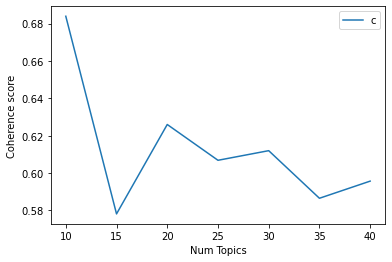

In [52]:
start=10; limit=41; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [53]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.6839
Num Topics = 15  has Coherence Value of 0.5781
Num Topics = 20  has Coherence Value of 0.626
Num Topics = 25  has Coherence Value of 0.6068
Num Topics = 30  has Coherence Value of 0.612
Num Topics = 35  has Coherence Value of 0.5865
Num Topics = 40  has Coherence Value of 0.5957


/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [54]:
# Select the model and print the topics
# optimal_model = model_list[4]
# optimal_model =  models.LdaModel.load('optimal_model.model')
# model_topics = optimal_model.show_topics(formatted=False)
# pprint(optimal_model.print_topics(num_words=10))

/opt/anaconda3/envs/U4-S1-NLP/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
